# LSTM pipeline

In [1]:
import io
import itertools
import warnings
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
def get_train_test_sets(csv_path: str = "Datasets/features_format_final.csv",forcast_days: int = 7) -> Tuple[pd.DataFrame, pd.DataFrame]:
    dataset = pd.read_csv(csv_path, parse_dates=["date"])
    dataset = dataset.sort_values("date")
    del dataset["region"]

    split_date = dataset["date"].max() - np.timedelta64(forcast_days, "D")
    train_df = dataset.loc[dataset["date"] < split_date]
    test_df = dataset.loc[dataset["date"] >= split_date]
    return train_df, test_df


train_df, test_df = get_train_test_sets()
train_df.describe()

,confirmed,recovered,deaths,S1_School closing,S1_IsGeneral,S2_Workplace closing,S2_IsGeneral,S3_Cancel public events,S3_IsGeneral,S4_Close public transport,...,S13_Contact tracing,StringencyIndex,StringencyIndexForDisplay,pct_positive,test_by_million,GDP per capita (current US$),Current health expenditure per capita (current US$),Population ages 65 and above (% of total population),Population density,Urban population (% of total population)
count,15484.000000,15484.00000,15484.000000,11182.000000,5418.000000,11023.000000,4567.000000,11120.000000,5440.000000,11002.000000,...,10328.000000,11008.000000,11008.000000,15484.000000,15484.000000,11929.000000,11139.000000,11376.000000,11929.000000,11929.000000
mean,100.920628,22.81891,6.162813,0.686550,0.774086,0.452327,0.617035,0.697392,0.719669,0.309853,...,0.651433,32.716625,32.716625,8.158371,7256.780173,17884.634399,1143.044892,9.305684,375.002208,61.472828
std,981.282468,227.61547,62.558985,0.944122,0.418221,0.789992,0.486163,0.932892,0.449202,0.694277,...,0.814507,34.061002,34.061002,5.028242,12284.430806,28086.364110,1797.106591,6.548501,1706.558571,22.465382
min,-15.000000,-268.00000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.110000,32.000000,271.752044,21.071156,1.370070,0.136497,13.032000
25%,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.900000,727.500000,2146.996385,78.822838,3.622314,30.983307,43.411000
50%,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,19.050000,19.050000,7.433333,1972.000000,6344.871979,339.327972,6.954369,85.687032,62.453000
75%,2.000000,0.00000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,...,1.000000,64.290000,64.290000,10.825000,12242.500000,19567.892435,1186.136353,14.850234,205.450748,80.102000
max,33267.000000,10219.00000,1973.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,...,2.000000,100.000000,100.000000,32.000000,112807.000000,185741.279992,9956.259766,27.576370,19196.000000,100.000000


In [3]:
train_df.isna().sum(axis=0)

date                                                        0
country                                                     0
confirmed                                                   0
recovered                                                   0
deaths                                                      0
country_code                                                0
S1_School closing                                        4302
S1_IsGeneral                                            10066
S2_Workplace closing                                     4461
S2_IsGeneral                                            10917
S3_Cancel public events                                  4364
S3_IsGeneral                                            10044
S4_Close public transport                                4482
S4_IsGeneral                                            11807
S5_Public information campaigns                          4457
S5_IsGeneral                                             8112
S6_Restr

In [4]:
def fill_na(
    train: pd.DataFrame, test: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = train.fillna(0)
    test = test.fillna(0)
    return train, test


train_df, test_df = fill_na(train_df, test_df)
display(train_df.isna().sum(axis=0))

date                                                    0
country                                                 0
confirmed                                               0
recovered                                               0
deaths                                                  0
country_code                                            0
S1_School closing                                       0
S1_IsGeneral                                            0
S2_Workplace closing                                    0
S2_IsGeneral                                            0
S3_Cancel public events                                 0
S3_IsGeneral                                            0
S4_Close public transport                               0
S4_IsGeneral                                            0
S5_Public information campaigns                         0
S5_IsGeneral                                            0
S6_Restrictions on internal movement                    0
S6_IsGeneral  

In [5]:
def add_last_cases_deaths(df: pd.DataFrame) -> pd.DataFrame:
    df["next_confirmed"] = df["confirmed"].shift(-1)
    df["next_deaths"] = df["deaths"].shift(-1)
    return df.drop(df.tail(1).index)


train_df = train_df.groupby(["country_code", "country"]).apply(add_last_cases_deaths).reset_index(drop=True)
", ".join(list(train_df))

'date, country, confirmed, recovered, deaths, country_code, S1_School closing, S1_IsGeneral, S2_Workplace closing, S2_IsGeneral, S3_Cancel public events, S3_IsGeneral, S4_Close public transport, S4_IsGeneral, S5_Public information campaigns, S5_IsGeneral, S6_Restrictions on internal movement, S6_IsGeneral, S7_International travel controls, S8_Fiscal measures, S9_Monetary measures, S10_Emergency investment in health care, S11_Investment in Vaccines, S12_Testing framework, S13_Contact tracing, StringencyIndex, StringencyIndexForDisplay, pct_positive, test_by_million, GDP per capita (current US$), Current health expenditure per capita (current US$), Population ages 65 and above (% of total population), Population density, Urban population (% of total population), next_confirmed, next_deaths'

In [72]:
class train_dataset(Dataset):
    def __init__(self, df: pd.DataFrame, length: int = 7):
        self.df = df.copy()
        self.length = length

    def __len__(self):
        return len(self.df) - self.length + 1

    def __getitem__(self, idx):
        first = self.df.iloc[idx]
        last = self.df.iloc[idx + self.length - 1]
        
        if first["country_code"] != last["country_code"]:
            for i in range(idx + 1, idx + self.length):
                if self.df.iloc[idx].country_code == last.country_code:
                    idx = i
                    break
            
        sample = self.df.iloc[idx : idx + self.length]
        current_day_data = sample[
            ["confirmed", 
#              "S1_School closing", "S1_IsGeneral",
#              "S2_Workplace closing", "S2_IsGeneral", "S3_Cancel public events", "S3_IsGeneral",
#              "S4_Close public transport", "S4_IsGeneral", "S5_Public information campaigns", "S5_IsGeneral",
#              "S6_Restrictions on internal movement", "S6_IsGeneral", "S7_International travel controls",
#              "S8_Fiscal measures", "S9_Monetary measures", "S10_Emergency investment in health care",
#              "S11_Investment in Vaccines", "S12_Testing framework", "S13_Contact tracing",
             "StringencyIndexForDisplay", "pct_positive", "test_by_million", "GDP per capita (current US$)",
             "Current health expenditure per capita (current US$)",
             "Population ages 65 and above (% of total population)", "Population density",
             "Urban population (% of total population)"]]
        current_day_data = torch.tensor(current_day_data.to_numpy()).float()

        next_day_cases = torch.tensor(sample.next_confirmed.to_numpy()).float()
    
        return current_day_data, next_day_cases


def MSLE_loss(one, two):
    loss = torch.mean((torch.log1p(one) - torch.log1p(two)) ** 2)  # MSLE loss
    return loss


class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x, future=0, repeat_features=None):

        outputs = []
        h_t = torch.zeros(x.size(0), self.hidden_size).float().cuda()
        c_t = torch.zeros(x.size(0), self.hidden_size).float().cuda()
        
        for i, input_t in enumerate(x.chunk(x.size(1), dim=1)):
            input_t = input_t.squeeze()
            
            if (input_t.dim() == 1):
                input_t = input_t.unsqueeze(dim=0)
            
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.fc1(h_t)
            output = torch.exp(self.fc2(output))
            outputs += [output]

        # outputs = [output]

        for i in range(future):  # if we should predict the future
            input_t = torch.cat((output, repeat_features), dim=1)
            
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.fc1(h_t)
            output = torch.exp(self.fc2(output))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


def train_model(dataset: Dataset, model: nn.Module, epochs: int = 60, batch_size=120):
    optimizer = optim.Adam(model.parameters(), lr=3e-3)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(epochs)):
        for x, cases in dataloader:
            x = x.cuda()
            cases = cases.cuda()
            
            model.zero_grad()
            cases_pred = model(x)
            
            loss = MSLE_loss(cases_pred, cases)
            
            loss.backward()
            optimizer.step()

In [ ]:
input_size = 9
hidden_size = 100


lstm = LSTM(input_size=input_size, hidden_size=hidden_size).cuda()
train_ds = train_dataset(train_df)
train_model(train_ds, lstm, epochs=50, batch_size=128)




  0%|          | 0/50 [00:00<?, ?it/s]


  2%|▏         | 1/50 [00:31<25:24, 31.11s/it]


  4%|▍         | 2/50 [01:02<24:55, 31.15s/it]


  6%|▌         | 3/50 [01:33<24:24, 31.15s/it]


  8%|▊         | 4/50 [02:04<23:52, 31.15s/it]


 10%|█         | 5/50 [02:35<23:22, 31.16s/it]


 12%|█▏        | 6/50 [03:06<22:48, 31.11s/it]


 14%|█▍        | 7/50 [03:37<22:16, 31.09s/it]


 16%|█▌        | 8/50 [04:08<21:45, 31.09s/it]


 18%|█▊        | 9/50 [04:39<21:12, 31.04s/it]


 20%|██        | 10/50 [05:10<20:40, 31.02s/it]


 22%|██▏       | 11/50 [05:41<20:08, 30.97s/it]


 24%|██▍       | 12/50 [06:13<19:51, 31.34s/it]


 26%|██▌       | 13/50 [06:46<19:28, 31.59s/it]


 28%|██▊       | 14/50 [07:18<19:01, 31.72s/it]


 30%|███       | 15/50 [07:48<18:20, 31.43s/it]


 32%|███▏      | 16/50 [08:19<17:43, 31.28s/it]

### Make one week prediciton based on the last 10 days

In [79]:
country = "Italy"

train_one_country = train_df[train_df["country"] == country]
test_one_country = test_df[test_df["country"] == country]

In [80]:
train_ds = train_dataset(train_one_country, length=10)
last_idx = len(train_ds) - 1
features, _ = train_ds[last_idx]
features = features.unsqueeze(0).cuda()
features.shape

torch.Size([1, 10, 9])

In [81]:
torch.save(lstm, "lstm.pt")

In [82]:
lstm = torch.load("lstm.pt")

In [83]:
repeat_features = features[0, -1:, 1:]

next_predictions = lstm.forward(features, 7, repeat_features)[0][-8:].detach()
next_predictions

tensor([0.4433, 0.4433, 0.4433, 0.4433, 0.4433, 0.4433, 0.4433, 0.4433],
       device='cuda:0')

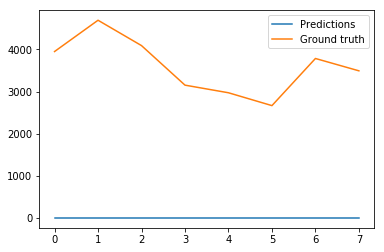

In [84]:
plt.plot(next_predictions.detach().cpu(), label="Predictions")
plt.plot(test_one_country["confirmed"].tolist(), label="Ground truth")
plt.legend()
plt.show()